In [6]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import networkx as nx  
from matplotlib import colormaps as cm
import seaborn as sns
import itertools

from matplotlib.ticker import MaxNLocator


path='C:/Users/Felix/Desktop/Máster  BD Deporte/Módulo 7 - Proveedores de Datos Deportivos/Liga Primera 23/f1/srml-23-2022-results.xml'

In [13]:
def results(path, team_difference=False):

    file = ET.parse(path)

    # Initialize data containers
    teams = {}
    data=[]

    # Iterate through XML tree
    for season in file.getroot():
        season_name = season.attrib.get("season_name")

        for team in season.findall("Team"):
            key=team.attrib.get("uID")
            name=team.find("Name").text
            teams[key]=name

        for match in season.findall("MatchData"):
            for stats in match.findall("MatchInfo"):
                match_day=stats.attrib.get("MatchDay")

            for stats in match.findall("TeamData"):
                if stats.attrib.get("Side")=="Home":
                    home_team=stats.attrib.get("TeamRef")
                    score_home=stats.attrib.get("Score")
                    
                else:
                    away_team=stats.attrib.get("TeamRef")
                    score_away=stats.attrib.get("Score")

            if team_difference==True:
                if int(match_day)<=19:
                    home_difference=int(score_home) - int(score_away) 
                    data.append([teams[home_team], teams[away_team],int(match_day), home_difference])
                else:
                    away_difference=int(score_away) - int(score_home)
                    data.append([teams[away_team], teams[home_team],int(match_day), away_difference])

            else:
                result="1" if score_home > score_away else "2" if  score_home < score_away  else "x" 
                data.append([season_name,match_day, teams[home_team],score_home,score_away, teams[away_team],result])

    if team_difference==True:
        df=pd.DataFrame(data, columns=["Local","Away","MatchDay","Goals difference"])
        df = df.sort_values(by='MatchDay')

        # Agrupamos por pares de equipos y calculamos la suma acumulada
        df['Teams Goal Difference'] = (
            df
            .groupby(['Local', 'Away'])['Goals difference']
            .cumsum()
        )
        df=df.reset_index(drop=True)
    else:
        df=pd.DataFrame(data, columns=["Season","MatchDay","Local","Local Goals","Away Goals","Away","Result"])

    return df

In [27]:
h2h_duels=results(path, team_difference=True)

In [ ]:
def global_balance(path):

    file = ET.parse(path)

    # Initialize data containers
    teams = {}
    data=[]

    # Iterate through XML tree
    for season in file.getroot():
        season_name = season.attrib.get("season_name")

        for team in season.findall("Team"):
            key=team.attrib.get("uID")
            name=team.find("Name").text
            teams[key]=name

        for match in season.findall("MatchData"):
            for stats in match.findall("MatchInfo"):
                jornada=stats.attrib.get("MatchDay")

            for stats in match.findall("TeamData"):
                if stats.attrib.get("Side")=="Home":
                    home_team=stats.attrib.get("TeamRef")
                    score_home=stats.attrib.get("Score")
                    
                else:
                    away_team=stats.attrib.get("TeamRef")
                    score_away=stats.attrib.get("Score")

            difference_home=int(score_home) - int(score_away)
            difference_away=int(score_away) - int(score_home)
            
            points_home=3 if difference_home > 0 else 0 if  difference_home < 0  else 1 
            points_away=3 if difference_away > 0 else 0 if  difference_away < 0  else 1 

            data.append([season_name,int(jornada), teams[home_team],int(score_home),difference_home,points_home])
            data.append([season_name,int(jornada), teams[away_team],int(score_away),difference_away,points_away])

    df1=pd.DataFrame(data, columns=["Season","MatchDay","Team","Goals scored","Goals Difference","Points"])
    df1['Points'] = df1.groupby('Team')['Points'].cumsum()
    df1['Goals Difference'] = df1.groupby('Team')['Goals Difference'].cumsum()
    df1['Goals scored'] = df1.groupby('Team')['Goals scored'].cumsum()
    df1=df1.reset_index(drop=True)

    return df1

In [28]:
balance=global_balance(path)
balance

,Season,MatchDay,Team,Goals scored,Goals Difference,Points
0,Season 2022/2023,1,Osasuna,2,1,3
1,Season 2022/2023,1,Sevilla,1,-1,0
2,Season 2022/2023,1,Barcelona,0,0,1
3,Season 2022/2023,1,Rayo Vallecano,0,0,1
4,Season 2022/2023,1,Celta de Vigo,2,0,1
...,...,...,...,...,...,...
755,Season 2022/2023,38,Sevilla,47,-7,49
756,Season 2022/2023,38,Real Valladolid,33,-30,40
757,Season 2022/2023,38,Getafe,34,-11,42
758,Season 2022/2023,38,Villarreal,59,19,64


In [ ]:
def tiebreaker(h2h_duels_df, global_balance_df, match_day,teams_list):
    lista=[]
    for teams in teams_list:
        team_a, team_b = teams
        h2h_duels_filtered=h2h_duels_df[(h2h_duels_df["Local"]==team_a) & (h2h_duels_df["Away"]==team_b)]
        if h2h_duels_filtered.empty==True:
            h2h_duels_filtered=h2h_duels_df[(h2h_duels_df["Away"]==team_b) & (h2h_duels_df["Away"]==team_a)]

        h2h_duels_filtered_matchday=h2h_duels_filtered[h2h_duels_filtered["MatchDay"]<= match_day].sort_values(by="MatchDay").head(1)
        h2h_duels_filtered_matchday=h2h_duels_filtered_matchday.reset_index(drop=True)
        ### Criterio diferencia de goles en duelos directos
        if (h2h_duels_filtered_matchday.empty==False) and (h2h_duels_filtered_matchday["Teams Goal Difference"] != 0).all():
            if (h2h_duels_filtered_matchday["Teams Goal Difference"]<0).all():
                lista.append([h2h_duels_filtered_matchday.loc[0,"Away"],h2h_duels_filtered_matchday.loc[0,"Local"]])
                
            elif (h2h_duels_filtered_matchday["Teams Goal Difference"] > 0).all():
                lista.append([h2h_duels_filtered_matchday.loc[0,"Local"],h2h_duels_filtered_matchday.loc[0,"Away"]])

        ### Criterio diferencia de goles acumulada
        else: 
            balance=global_balance_df[global_balance_df["MatchDay"]==match_day]
            balance_team_a=int(balance[balance["Team"]==team_a]["Goals Difference"].values[0])      
            balance_team_b=int(balance[balance["Team"]==team_b]["Goals Difference"].values[0])
            if balance_team_a > balance_team_b:
                lista.append([team_a,team_b])
            elif balance_team_a < balance_team_b:
                lista.append([team_b,team_a])
            else: 
                ### Criterio goles a favor
                goles_team_a=int(balance[balance["Team"]==team_a]["Goals scored"].values[0])
                goles_team_b=int(balance[balance["Team"]==team_b]["Goals scored"].values[0])
                if goles_team_a > goles_team_b:
                    lista.append([team_a,team_b])
                elif goles_team_a < goles_team_b:
                    lista.append([team_b,team_a])  
        
    # print(lista)
    G = nx.DiGraph()
    G.add_edges_from(lista)
    # Función para romper ciclos
    def break_cycles(graph):
        graph_copy = graph.copy()
        while True:
            try:
                list(nx.topological_sort(graph_copy))
                break  # No hay ciclos
            except nx.NetworkXUnfeasible:
                cycle = list(nx.find_cycle(graph_copy, orientation='original'))
                edge_to_remove = cycle[-1][:2]  # Eliminar última arista del ciclo
                graph_copy.remove_edge(*edge_to_remove)
        return graph_copy

    # Aplicar algoritmo
    G_acyclic= break_cycles(G)

    # Perform topological sort
    sorted_list = list(nx.topological_sort(G_acyclic))

    return sorted_list


In [ ]:
def league_table(h2h_duels_df, global_balance_df):
    
    result = pd.DataFrame()

    for match_day in np.sort(global_balance_df["MatchDay"].unique()):
        df_filtered = global_balance_df[global_balance_df["MatchDay"] == match_day].copy()
        df_filtered['Points_adjust'] = df_filtered['Points'].astype(float)  

        # Encontramos los registros con puntos duplicados
        df_filtered_dup = df_filtered[df_filtered.duplicated(subset="Points", keep=False)]

        for puntos in df_filtered_dup["Points"].unique():
            df_filtered_pt = df_filtered_dup[df_filtered_dup["Points"] == puntos]

            # Lista de tuplas con las distintas combinaciones posibles
            teams = list(itertools.combinations(df_filtered_pt["Team"].unique(), 2))
            
            # Almacenamos el resultado de desempate para evitar llamarlo varias veces
            desempate_list = tiebreaker(h2h_duels_df, global_balance_df, match_day,teams)
            # desempate(jornada, teams)
            
            if desempate_list:
                desempate_dict={}
                # Map adjustments only to relevant rows
                for x in desempate_list:
                    desempate_dict[x]=(len(desempate_list)-desempate_list.index(x))/(len(desempate_list)+1)
                
                for equipo, ajuste in desempate_dict.items():
                    df_filtered.loc[df_filtered["Team"] == equipo, "Points_adjust"] += ajuste

        result = pd.concat([result, df_filtered], ignore_index=True)

    # # Final cleanup
    result = result.drop_duplicates().reset_index(drop=True)

    result_sorted = result.sort_values(by=["MatchDay",'Points_adjust'], ascending=[True, False])

    # # Añadimos la columna de clasificación
    result['League Position'] = result_sorted.groupby('MatchDay').cumcount() + 1
    # # df1['Clasificación']=df1['Clasificación'].astype("string")
    result=result.sort_values(by=["MatchDay","League Position"])
    result=result.reset_index(drop=True)
    result=result.drop(columns=["Points_adjust"])  

    return result  

In [52]:
league_table_df=league_table(h2h_duels,balance)
league_table_df

,Season,MatchDay,Team,Goals scored,Goals Difference,Points,League Position
0,Season 2022/2023,1,Villarreal,3,3,3,1
1,Season 2022/2023,1,Atlético de Madrid,3,3,3,2
2,Season 2022/2023,1,Real Betis,3,3,3,3
3,Season 2022/2023,1,Osasuna,2,1,3,4
4,Season 2022/2023,1,Real Madrid,2,1,3,5
...,...,...,...,...,...,...,...
755,Season 2022/2023,38,Cádiz,30,-23,42,16
756,Season 2022/2023,38,Almería,49,-16,41,17
757,Season 2022/2023,38,Real Valladolid,33,-30,40,18
758,Season 2022/2023,38,Espanyol,52,-17,37,19


In [57]:

def plot_league_table(league_table_df):
    # Estilo visual
    sns.set_style("whitegrid")

    # Datos simulados

    # Crear DataFrame
    df = league_table_df[["MatchDay","Team","League Position"]]

    # Crear figura y eje principal
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Eje Y izquierdo - Equipo
    colores_equipos = dict(zip(df['Team'].unique(), sns.color_palette("tab20", len(df['Team'].unique()))))


        
    ax1.set_xlabel('MatchDay')
    ax1.set_ylabel('Team')
    jornada_1=df[df['MatchDay']==1].sort_values("League Position",ascending=False)
    ax1.plot(jornada_1['MatchDay'], jornada_1['Team'], marker=',',color="white", label='Team')
    ax1.tick_params(axis='y')

    # Eje Y derecho - League Position
    ax2 = ax1.twinx()
    # color_clasificacion = 'tab:white'
    ax2.set_ylabel('League Position')
    for equipo in np.sort(df['Team'].unique()):
        datos_equipo = df[df['Team'] == equipo]
        ax2.plot(datos_equipo['MatchDay'], datos_equipo['League Position'],color=colores_equipos[equipo], linestyle='--', marker='s', label='League Position')

    min_y=int(min(jornada_1["League Position"]))
    max_y=int(max(jornada_1["League Position"]))
    ax2.set_yticks(range(min_y, max_y + 1))
    # ax2.tick_params(axis='y', labelcolor=color_clasificacion)
    ax2.set_ylim(ax2.get_ylim()[::-1])

    # Título y leyenda
    fig.suptitle("Development of team's League Position by Match Day", fontsize=14)
    fig.tight_layout()
    plt.show()


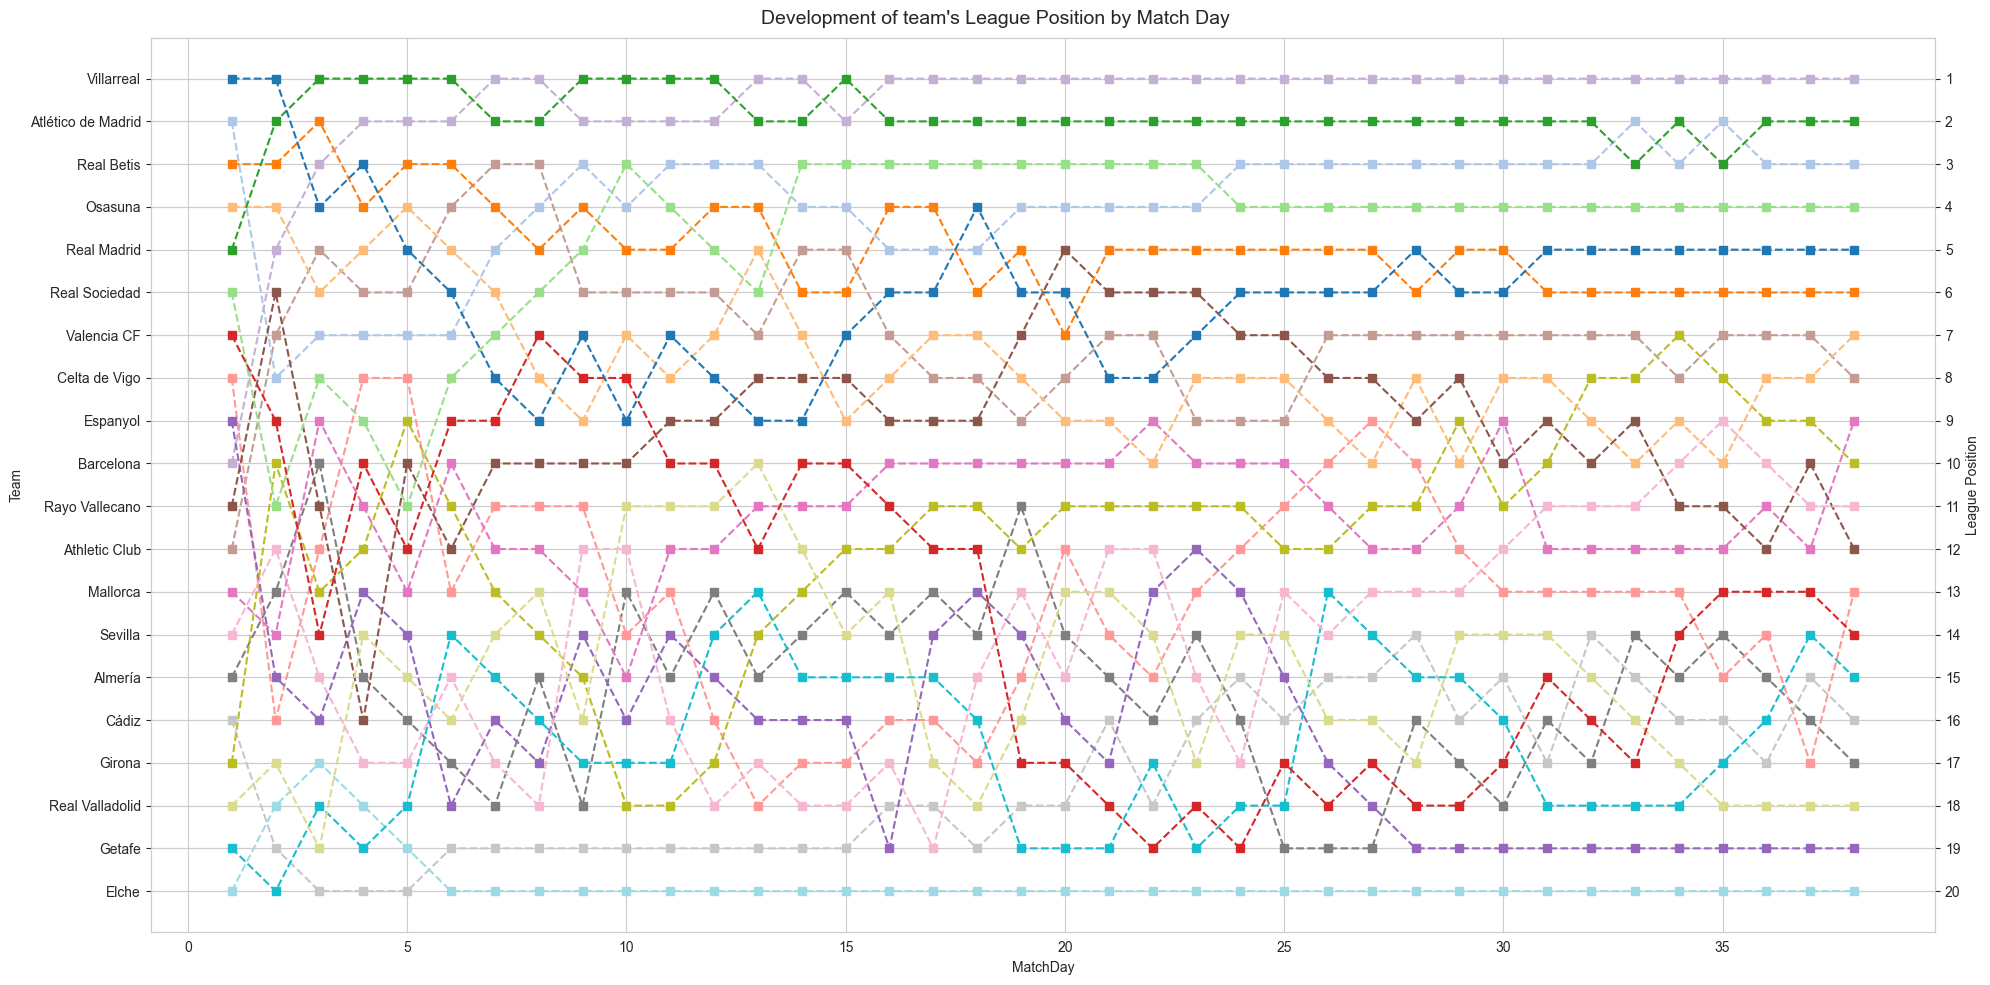

In [58]:
plot_league_table(league_table_df)